In [ ]:
import mph
import os
import numpy as np
import matplotlib.pyplot as plt

In [66]:
class QFactor:
    """ Base class to calculate Q-Factors. Follows (which papers) and (which code?)"""
    
    def __init__(self, filepath, label_data_set, label_mesh):
        # load model
        self.model = None
        self.client = mph.start(cores=1)  # start MPH client
        self.load_model(filepath)
        
        # load mesh & mesh grid
        self.mesh = None
        self.mesh_grid = None
        assert isinstance(label_mesh, str), "Provide a string label"
        self.load_mesh(label_mesh) 
        
        # load data set
        self.data_set = None
        assert isinstance(label_data_set, str), "Provide a string label"
        self.data_set = self.load_dataset(label_data_set)
        self.label_dataset = label_data_set
        
        self.expr = None  # evaluation object
        self.expr_tag = None  # tag for evaluation object
        self.grid_square = None # NumPy array with Shape (3, NumITP-Points)
        
        self.results = {}  # stores results
        self.params = {}  # stores parameters from COMSOL
        
    def load_mesh(self, label_mesh):
        self.mesh = self.model.component("comp1").mesh(label_mesh)
        self.mesh_grid = np.array(self.mesh.getVertex())
        
    def load_dataset(self, label_data_set):
        self.data_set = self.model.result().dataset(label_data_set)
        # assert that data set has a solution
        solution_name = self.data_set.getString("solution")
        if self.model.sol(solution_name).isEmpty():
            self.data_set = None
            raise RuntimeError("Loaded data set has no solution")
        
    def load_model(self, filepath):
        """ Load COMSOL model to MPH base object."""
        if not os.path.exists(filepath):
            raise FileExistsError(f"File {filepath} does not exist")
        
        model_mph = self.client.load(filepath)  # load COMSOL model
        self.model = model_mph.java
        
    def clear_all_models(self):
        self.client.clear()
        
    def set_expr(self, expr_list=None, kind="Interp"):
        """Set a list of expressions to evaluate"""
        if kind not in ["Interp", "Eval"]:
            raise ValueError("Valid expression types are Interp and Eval")
        
        if expr_list is not None:
            assert isinstance(expr_list[0], str), "Provide a list of strings as input"
            self.expr_tag = "custom"
        else:
            self.expr_tag = "default"
            expr_list = ["w", "dtang(dtang(w, x), x)", "dtang(dtang(w, y), y)", "dtang(dtang(w, x), y)"]
        
        # choose dataset for which to evaluate the above expression
        self.expr =  self.model.result().numerical().create(self.expr_tag, kind)
        self.expr.set("data", self.label_dataset)
        self.expr.set("expr", expr_list)
        
    def set_grid_square(self, width_um_cell=1, width_um_square=300):
        """Set grid with spacing width_um_cell and size width_um_square."""
        lb, rb = - width_um_square / 2, width_um_square / 2
        num_points = int(width_um_square / width_um_cell) + 1
        x = np.linspace(lb, rb, num_points, endpoint=True)
        assert np.all(np.diff(x, axis=0) == width_um_cell)

        x, y = np.meshgrid(x, x) # extend to grid
        x, y = x.flatten(), y.flatten()  # flatten grid
        z = np.array([0.] * len(x))
        
        self.grid_square = np.array([x, y, z])
        
    def evaluate_expr_default(self, sol_number=0):
        """ Evaluate expression on data points from data set."""
        if self.expr_tag != "default": 
            raise NotImplementedError("Only implemented for default list currently.")
        
        # Evaluate on mesh grid - use to integrate on rectangular mesh areas
        self.expr.setInterpolationCoordinates(self.mesh_grid)
        self.results["dxx_df"] = np.array(self.expr.getData(1))[sol_number]  # units 1/m
        self.results["dyy_df"] = np.array(self.expr.getData(2))[sol_number]
        self.results["dxy_df"] = np.array(self.expr.getData(3))[sol_number]
        
    def evaluate_expr(self, sol_number=0):
        """ Brute-force solution. First evaluate the expression on the mesh grid, then on the 
        interpolation grid. Future: Speed-up"""
        if self.expr_tag != "default": 
            raise NotImplementedError("Only implemented for default list currently.")
        
        # Evaluate on mesh grid - use to integrate on rectangular mesh areas
        self.expr.setInterpolationCoordinates(self.mesh_grid)
        self.results["dxx_m"] = np.array(self.expr.getData(1))[sol_number]  # units 1/m
        self.results["dyy_m"] = np.array(self.expr.getData(2))[sol_number]
        self.results["dxy_m"] = np.array(self.expr.getData(3))[sol_number]
        
        # Evaluate on square grid - use to integrate on coarse areas
        self.expr.setInterpolationCoordinates(self.grid_square)
        self.results["dxx_s"] = np.array(self.expr.getData(1))[sol_number]
        self.results["dyy_s"] = np.array(self.expr.getData(2))[sol_number]
        self.results["dxy_s"] = np.array(self.expr.getData(3))[sol_number]
        
    def load_mask(self):
        """ Get boolean mask for numerical integration. Divide domain into two regions A and B, 
        where we use mesh coordinates to integrate in A and square coordinates to integrate in B."""
        # Mask mesh
        mesh_x, mesh_y, _ = self.mesh_grid
        mask_xf = np.logical_and(mesh_x >= 149.1, mesh_x <= -149.1) # only used for mesh coordinates
        mask_yf = np.logical_and(mesh_y >= 149.1, mesh_y <= -149.1)
        mask_fine = np.logical_xor(mask_xf, mask_yf)  # XOR to have domain A not in edges
        
        # is NOT the complement of mask_fine as they refer to different data sets
        grid_x, grid_y, _ = self.grid_square
        mask_xc = np.logical_and(grid_x < 149.1, grid_x > -149.1) # only used for mesh coordinates
        mask_yc = np.logical_and(grid_y < 149.1, grid_y > -149.1)
        mask_coarse = np.logical_not(np.logical_xor(mask_xc, mask_yc))  # XNOR to have domain B also in edges
        
        self.results["mask_fine"] = mask_fine
        self.results["mask_coarse"] = mask_coarse
        
    def calculate_mean_curvature(self, dxf_um=1, dyf_um=1, ds_um=1):
        """Evaluate the integral dx dy (wxx + wyy)^2 in SI units."""
        # convert to m
        dxf, dyf, ds = dxf_um * 1e-6, dyf_um * 1e-6, ds_um * 1e-6
        
        mf = self.results["mask_fine"]
        to_sum_fine = self.results["dxx_m"][mf] + self.results["dyy_m"][mf]
        mc = self.results["mask_coarse"]
        to_sum_coarse = self.results["dxx_s"][mc] + self.results["dyy_s"][mc]
        
        self.results["mean_curvature"] = np.sum(to_sum_fine ** 2) * dxf * dyf + ds**2 * np.sum(to_sum_coarse ** 2)
        
    def load_global_params(self):
        """Load all global parameters from COMSOL."""
        self.params = {name: self.model.param().get(name) for name in self.model.param().varnames()}
        
    def get_energy(self, energy=None, tag="int1", sol_number=0):
        """ Load the integration node with tag -tag- that is defined in COMSOL, evaluate it, and 
         store result selected by solution number. """
        if energy is None:
            expr = self.model.result().numerical(tag)  # load evaluation node with tag
            energy = np.squeeze(np.array(expr.getReal()))[sol_number]
        
        self.results["mode_energy"] = energy
        
    def load_material_params(self, tag_material="mat1"):
        """Loads Poisson ratio and Young's modulus parameters. 
        See https://doc.comsol.com/5.5/doc/com.comsol.help.comsol/comsol_ref_materials.16.09.html"""
        mm = self.model.component("comp1").material(tag_material).propertyGroup("Enu")
        self.params['young_modulus'] = int(mm.getString("youngsmodulus")[:3]) * 1e9  # units GPa
        self.params["poisson_ratio"] = float(str(mm.getString("poissonsratio")))
        
    def get_q_factor(self, dx=1, dy=1):
        """ Calculate Q Factor based on YH thesis, using parameters stored in COMSOL."""
        E2 = self.params['young_modulus'] / (5.7e10 * self.params["thickSiN"])  # from Villanueva 2014
        
        factor = dx * dy * self.params["thickSiN"] ** 3 * \
                 np.pi * E2 / (12 * (1 - self.params["poisson_ratio"]**2))
        
        self.results["dw"] = factor * np.sum((self.results["deriv_xx"] + self.results["deriv_yy"]) ** 2)
        
        self.results["dw_full"] = factor * np.sum((self.results["deriv_xx"] + self.results["deriv_yy"]) \
                                       ** 2 - 2 * (1 - self.params["poisson_ratio"]) \
                                       * (self.results["deriv_xx"] * self.results["deriv_yy"]
                                          - self.results["deriv_xy"] ** 2))
        
        q_factor = 2 * np.pi * self.results["mode_energy"] / self.results["dw"]
        
        q_factor_full = 2 * np.pi * self.results["mode_energy"] / self.results["dw_full"]
        
        return q_factor, q_factor_full

In [68]:
directory = "D:\COMSOL\Leo"
fp = os.path.join(directory, "SiN_Membrane_HardClamped_V2.mph")
lb_ds = "dset5"
lb_mesh = "mesh5"
width_cell_um = 1
l_membrane = 300 # um, should be integer multiple of width_cell_um

result = QFactor(fp, lb_ds, lb_mesh)

# Set default expression and square interpolation grid
result.set_expr()
result.set_grid_square(width_um_cell=width_cell_um, width_um_square=l_membrane)

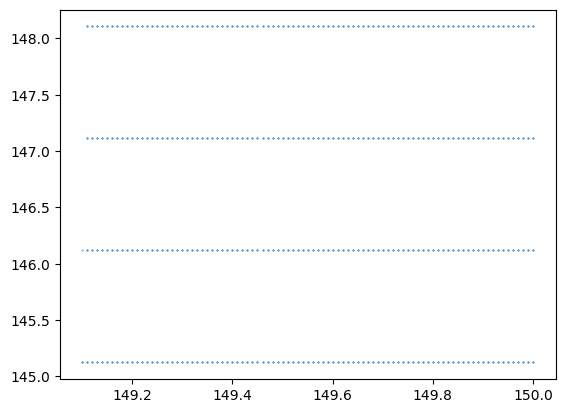

In [69]:
xm, ym, zm = result.mesh_grid
xs, ys, zs = result.grid_square

mm = np.logical_and(xm > 149.1, np.logical_and(ym > 145, ym < 149))
xmt, ymt = xm[mm], ym[mm]

plt.scatter(xmt, ymt, s=0.1)

# print(xmt, ymt)

In [70]:
result.evaluate_expr(sol_number=0)

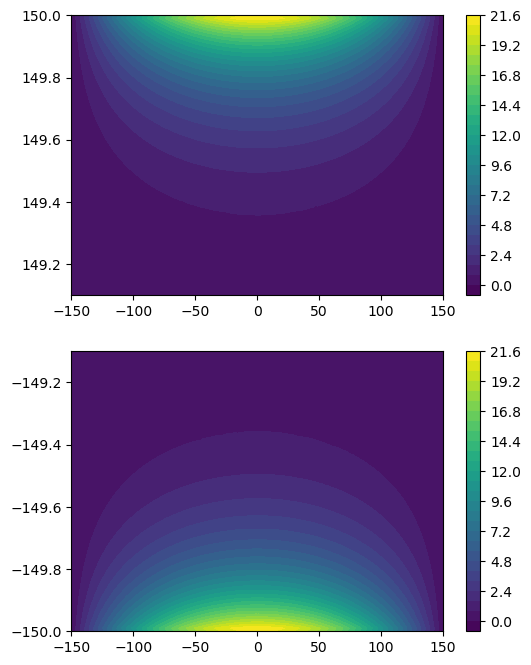

In [71]:
wxx_m = result.results["dxx_m"]
wyy_m = result.results["dyy_m"]

mask_test_pos = ym > 149
mask_test_neg = ym < -149

fig_heatmap, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))

triplot1 = ax1.tricontourf(xm[mask_test_pos], ym[mask_test_pos], wyy_m[mask_test_pos], levels=30)
fig_heatmap.colorbar(triplot1, ax=ax1)

triplot2 = ax2.tricontourf(xm[mask_test_neg], ym[mask_test_neg], wyy_m[mask_test_neg], levels=30)
fig_heatmap.colorbar(triplot2, ax=ax2)

plt.show()

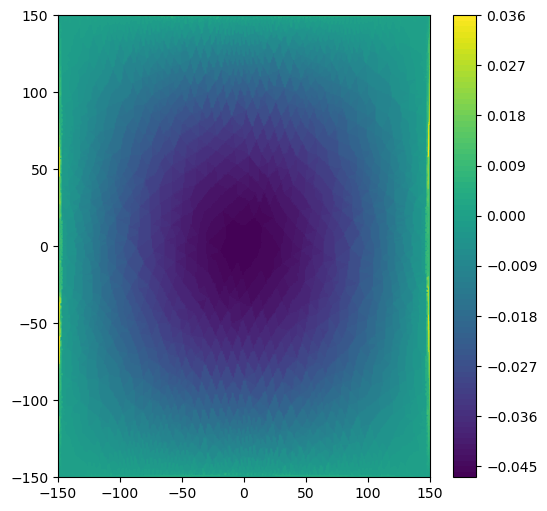

In [35]:
wxx_s = result.results["dxx_s"]

mask_xg = np.logical_and(xs < 149.1, xs > -149.1)
mask_yg = np.logical_and(ys < 149.1, ys > -149.1)
mask_coarse_t = np.logical_not(np.logical_xor(mask_xg, mask_yg))

fig_heatmap, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
triplot3 = ax.tricontourf(xs[mask_coarse_t], ys[mask_coarse_t], wxx_s[mask_coarse_t], levels=100)
fig_heatmap.colorbar(triplot3, ax=ax)

In [72]:
result.load_mask()  # uses 149.1

In [76]:
mesh_a_um, mesh_b_um = (300 - 1.8) / 300, 0.01
print(mesh_a_um, mesh_b_um)

result.calculate_mean_curvature(ds_um=width_cell_um, dxf_um=mesh_a_um, dyf_um=mesh_b_um)

int_surface = result.results["mean_curvature"]

q_int = 2850
E1 = 200 * 1e9
nu = 0.27
h = 50 * 1e-9

dw_test = np.pi * E1 * h**3 / (q_int * 12 * (1 - nu**2)) * int_surface

print(int_surface)
print(dw_test)

0.994 0.01
1.954902897734563e-10
4.842419219275462e-25
